In [3]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from rad_utils import remove_all_ticks_and_labels
from tqdm.auto import tqdm, trange

returning as tensor


[Text(0.5, 1.0, 'Ground Truth Manifold')]

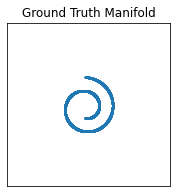

In [4]:
# import dataset
from generate_data import load_unimodal_data, load_unimodal_data_3d, load_unimodal_data_nd, make_nd_dataset
from rad_utils import generate_2d_swiss_roll

gt_manifold_t, gt_manifold, _, _ = generate_2d_swiss_roll(1e4, return_as_tensor=True)
# gt_manifold = load_unimodal_data(1e4, manifold_type='line', plot=False)

fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.scatter(*gt_manifold.T, s=1)
ax.set_aspect('equal')
lims=[-3, 3]
ax.set(xlim=lims, ylim=lims)
remove_all_ticks_and_labels(ax)
ax.set(title='Ground Truth Manifold')

# Networks

So what do we want? We want every neuron in the network to have some stochasticity.

## network with stochastic neurons


In [5]:
# define the model
class StochasticNeuron(nn.Module):
    '''
    A custom module. Defines a linear matrix and an embedding matrix. 
    '''
    def __init__(self, num_in, num_out):
        super(StochasticNeuron, self).__init__()
        self.num_in = num_in  # 2 for a 2 pixel image
        self.num_out = num_out  # size of the hidden layer, e.g. 32
        self.linear = nn.Linear(num_in + 1, num_out)  # A normal linear layer, 3x32
        
    def forward(self, x, t):
        t = t.float().view(len(t), 1)
        
        out = torch.cat((x, t), dim=1)
        out = self.linear(out)
        out = out + t/100 * torch.randn_like(out)
        return out
    

class SNN(nn.Module):
    def __init__(self, num_hidden):
        super(SNN, self).__init__()
        self.condlin1 = StochasticNeuron(2, num_hidden)
        self.condlin2 = StochasticNeuron(num_hidden, num_hidden)
        self.condlin3 = StochasticNeuron(num_hidden, num_hidden)
        self.linear = nn.Linear(num_hidden, 2)
        self.nonlin = nn.ReLU()
        
    def forward(self, x, t):
        '''
        x is the image
        t is the timestep
        '''
        x = self.condlin1(x, t)
        x = self.nonlin(x)

        x = self.condlin2(x, t)
        x = self.nonlin(x)

        x = self.condlin3(x, t)
        x = self.nonlin(x)

        x = self.linear(x)
        
        return x

## single layer network 

(or, equivalently, stochasticity after every layer) of a big feedforward neural network

In [6]:
# define the model
class NoiseConditionalLinearConcat(nn.Module):
    '''
    A custom module. Defines a linear matrix and an embedding matrix. 
    '''
    def __init__(self, num_in, num_out):
        super(NoiseConditionalLinearConcat, self).__init__()
        self.num_in = num_in  # 2 for a 2 pixel image
        self.num_out = num_out  # size of the hidden layer, e.g. 32
        self.linear = nn.Linear(num_in + 1, num_out)  # A normal linear layer, 3x32
        
    def forward(self, x, t):
        t = t.float().view(len(t), 1)
        
        out = torch.cat((x, t), dim=1)
        out = self.linear(out)
        return out

class SingleLayerNetwork(nn.Module):
    def __init__(self, num_hidden):
        super(SingleLayerNetwork, self).__init__()
        self.condlin1 = NoiseConditionalLinearConcat(2, num_hidden)
        self.linear = nn.Linear(num_hidden, 2)
        self.nonlin = nn.ReLU()
        
    def forward(self, x, t):
        '''
        x is the image
        t is the timestep
        '''
        x = self.condlin1(x, t)
        x = self.nonlin(x)

        x = self.linear(x)
        return x

# training

In [11]:
# training process
from utils import forward_process, noise_estimation_loss
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import time

def reverse_process(model, model_name, model_number, num_steps, num_hidden, num_dims, num_epochs, batch_size, lr, device, dataset, pretrained_model):
    # beta-related parameters
    coefs = forward_process(num_steps, device)
    betas, alphas, alphas_prod, alphas_prod_p, alphas_bar_sqrt, one_minus_alphas_prod_log, one_minus_alphas_prod_sqrt = coefs
    alphas_bar_sqrt = alphas_bar_sqrt.to(device)
    one_minus_alphas_prod_sqrt = one_minus_alphas_prod_sqrt.to(device)
    
    # training set
    dataset = dataset.to(device)
    
    # define model
    if pretrained_model['use_pretrained_model_weights']:
        from utils import load_model_weights
        pretrained_model_name = pretrained_model['model_name']
        pretrained_model_num = pretrained_model['model_num']
        print(f'taking weights from pretrained model {pretrained_model_name}_{pretrained_model_num}!')
        model = load_model_weights(model, pretrained_model_name, pretrained_model_num, device)
    model.to(device)

    # training parameteres
    optimizer = optim.Adam(model.parameters(), lr=lr)

    tb = SummaryWriter(f'runs/{model_name}_{model_number}')
    start_time = time.time()
    
    # start training
    model.train()
    for t in trange(int(num_epochs), desc='Training model', unit='epochs'):
        permutation = torch.randperm(dataset.size()[0], device=device)
    
        for i in range(0, dataset.size()[0], batch_size):
            # retrieve current batch
            indices = permutation[i:i+batch_size]
            batch_x = dataset[indices]
            
            # compute the loss
            loss = noise_estimation_loss(model, batch_x, num_steps, alphas_bar_sqrt, one_minus_alphas_prod_sqrt, device, norm='l2', has_class_label=False)
            # zero the gradients
            optimizer.zero_grad()
            # backward pass: compute the gradient of the loss wrt the parameters
            loss.backward()
            # call the step function to update the parameters
            optimizer.step()
        
        # write to tensorboard
        tb.add_scalar('Loss', loss.item(), t)

        # print loss
        if (t % (num_epochs/10) == 0):
            print('t', t)
            print('loss', loss.item())
    tb.flush()

    end_time = time.time()
    duration = end_time - start_time
    duration_mins = duration / 60
    print(f'training took {duration:.0f} seconds, which is {duration_mins:.2f} minutes.')
    return model

# run

In [169]:
# define hyperparameter values
global device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model_name = 'single_layer_network'
model_name = 'snn3'
# model_name = 'unconditional-concat'

model_number = 2
num_steps = 100
num_hidden = 42
num_ambient_dims = 2
epochs = 7e3
batch_size = 128
lr = 3e-4
pretrained_model = {
    'use_pretrained_model_weights': False,
    'model_name': 'snn',
    'model_num': 8
}

# model = SingleLayerNetwork(num_hidden)
# model = SNN2(num_hidden)
model = SNN3(num_hidden)

# from models import NoiseConditionalEstimatorConcat
# model = NoiseConditionalEstimatorConcat(num_hidden)

_, dataset, _, _ = generate_2d_swiss_roll(1e4, return_as_tensor=True)
# dataset = load_unimodal_data(1e4, manifold_type='line', plot=False)

# -------------------- TRAINING - reverse diffusion process ------------------ #
model = reverse_process(model, model_name, model_number, num_steps, num_hidden, num_ambient_dims, epochs, batch_size, lr, device, dataset, pretrained_model)
from utils import save_model_weights
save_model_weights(model, model_name, model_number)

returning as tensor


Training model:   0%|          | 0/7000 [00:00<?, ?epochs/s]

t 0
loss 0.9665676951408386
t 700
loss 0.6378529071807861
t 1400
loss 0.558138370513916
t 2100
loss 0.919678807258606
t 2800
loss 0.5497161149978638
t 3500
loss 0.3383704721927643
t 4200
loss 0.462386816740036
t 4900
loss 0.500584065914154
t 5600
loss 0.275577187538147
t 6300
loss 0.26973554491996765
training took 318 seconds, which is 5.31 minutes.
model state dict saved in directory: ./saved_weights/


# testing

model loaded!


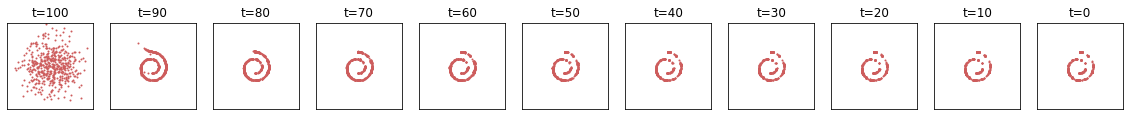

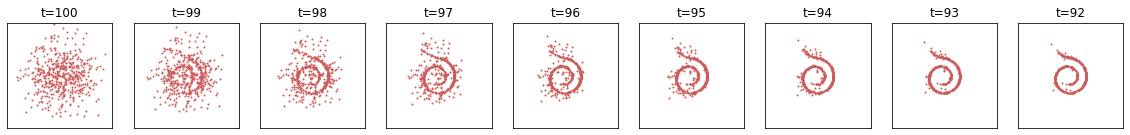

In [177]:
from generate_data import p_sample_loop, p_sample_loop_new, p_sample_loop_snn
from utils import forward_process, load_model_weights
from models import NoiseConditionalEstimatorConcat

sample_size = 5e2
lims = [-3,3]

num_hidden = 42

# model = SingleLayerNetwork(num_hidden)
# model = load_model_weights(model, 'single_layer_network', 10, device)

model = SNN3(num_hidden)
model = load_model_weights(model, 'snn3', 2, device)

# model = NoiseConditionalEstimatorConcat(num_hidden)
# model = load_model_weights(model, 'unconditional-concat', 16, device)

# x_seq = p_sample_loop_new(model, (int(sample_size), num_ambient_dims), num_steps, device)  # with sampling noise
x_seq = p_sample_loop_snn(model, (int(sample_size), num_ambient_dims), num_steps, device)  # withouth sampling noise

fig, axes = plt.subplots(1, 11, figsize=(20, 3), sharey=True)
for i in range(0, 11):
    cur_x = x_seq[i * 10].detach().cpu()
    ax = axes[i]
    ax.scatter(cur_x[:, 0], cur_x[:, 1],color='white',edgecolor='indianred', s=1);
    ax.set_aspect('equal')
    ax.set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(ax)
    ax.set(title=f't={100-i*10}')
    
fig, axes = plt.subplots(1, 9, figsize=(20, 3), sharey=True)
i = 0
for ax in axes:
    ax.scatter(x_seq[i][:, 0], x_seq[i][:, 1],color='white',edgecolor='indianred', s=1)
    ax.set_aspect('equal')
    ax.set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(ax)
    ax.set(title=f't={100-i}')
    i += 1

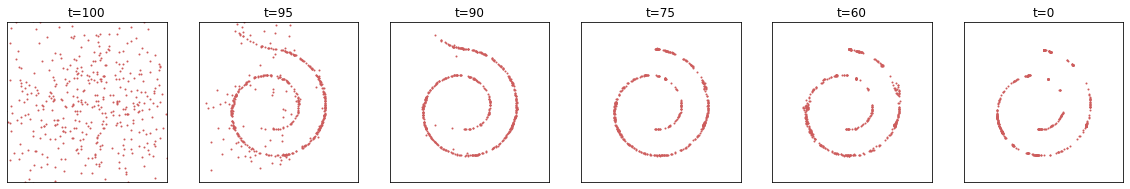

In [178]:
idx = [0, 5, 10, 25, 40, 100]
fig, axes = plt.subplots(1, len(idx), figsize=(20, 5))
i = 0
for ax in axes:
    # display the actual manifold
    # ax.scatter(*gt_manifold.T, s=0.5, color='orange', alpha=0.1)
    
    # display the model output
    cur_x = x_seq[idx[i]].detach().cpu()
    ax.scatter(cur_x[:, 0], cur_x[:, 1], color='indianred', s=1)
    
    ax.set_aspect('equal')
    lims=[-1.5, 1.5]
    ax.set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(ax)
    ax.set(title=f't={100-idx[i]}')
    
    
    i+=1
    

Wow!! The SNN works pretty well. 

The changes I made: 
- The inference process removes the added stochasticity at the end (the information destroying operator) 
- For the training error we use L2 norm rather than L1 norm

A couple of observations:
- It seems like most of the processing is happening in the first couple of time indices (wonder if it's because I'm interpolating t from 1 to 0 linearly in the network? or if it's because I'm overfitting? or if it's overshooting?)
- Towards the end (t=0) we're getting a non-uniform distribution of sampled points
- The anti-diffusion steps look less like it's driven by a flow field? 
- We have a small number of neurons per layer (64), which is much less than the 128 I was using for the vanilla non-stochastic network -- can we use even fewer neurons? 
- in a way, it should of course work, a la cold diffusion, because the operator we're using is just a more complex stochastic (continuous) noising operator. 


what if the degree of noise didn't follow a schedule, and just had a fixed value (less than 1)?
right now it seems like it's showing that beyond a certain amount of noise (=1), the denoiser is unable to denoise the image. 


smallest beta: tensor(5.9428e-05) 
largest beta: tensor(0.0200) 
so the noise never reaches 0 for the beta schedule!


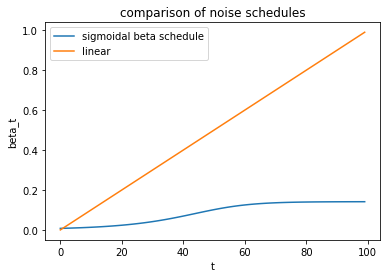

In [124]:
# linear vs sigmoidal decay of t:
from utils import forward_process, extract
coefs = forward_process(num_steps, device)
betas, alphas, alphas_prod, alphas_prod_p, alphas_bar_sqrt, one_minus_alphas_prod_log, one_minus_alphas_prod_sqrt = coefs

# sigma_t = extract(betas, t, x).sqrt()

fig, ax = plt.subplots(1, 1)
ts = np.arange(0, betas.shape[0])
ax.plot(ts, betas.sqrt(), label='sigmoidal beta schedule')
ax.set(xlabel='t', ylabel='beta_t')

ax.plot(ts, ts/100, label='linear')

ax.legend()
ax.set(title='comparison of noise schedules')

print('smallest beta:', betas[0], '\nlargest beta:', betas[99], '\nso the noise never reaches 0 for the beta schedule!')




In [163]:

t = torch.tensor(np.array([1, 2, 3, 4, 5, 6]))
t = extract(betas, t, t)
print(t)

t = torch.tensor([1, 2, 3, 4, 5, 6]).view(-1, 1)
print(t.shape)
t = t.long()
print(t[0].dtype)
b = betas.reshape(-1, 1)
t = extract(b, t, t)
print(t)

tensor([6.5779e-05, 7.2945e-05, 8.1027e-05, 9.0143e-05, 1.0042e-04, 1.1202e-04])
torch.Size([6, 1])
torch.int64
tensor([[6.5779e-05],
        [7.2945e-05],
        [8.1027e-05],
        [9.0143e-05],
        [1.0042e-04],
        [1.1202e-04]])


# SNN 2 with different noise location

In [89]:
# define the model
class StochasticNeuron2(nn.Module):
    '''
    A custom module. Defines a linear matrix and an embedding matrix. 
    '''
    def __init__(self, num_in, num_out):
        super(StochasticNeuron2, self).__init__()
        self.num_in = num_in  # 2 for a 2 pixel image
        self.num_out = num_out  # size of the hidden layer, e.g. 32
        self.linear = nn.Linear(num_in + 1, num_out)  # A normal linear layer, 3x32
        
        
    def forward(self, x, t):
        t = t.float().view(len(t), 1)
        
        out = torch.cat((x, t), dim=1)
        out = self.linear(out)
        # out = out + t/100 * torch.randn_like(out)
        return out
    

class SNN2(nn.Module):
    def __init__(self, num_hidden):
        super(SNN2, self).__init__()
        self.condlin1 = StochasticNeuron2(2, num_hidden)
        self.condlin2 = StochasticNeuron2(num_hidden, num_hidden)
        self.condlin3 = StochasticNeuron2(num_hidden, num_hidden)
        self.linear = nn.Linear(num_hidden, 2)
        self.nonlin = nn.ReLU()
        self.beta = nn.Parameter(torch.tensor(0.0001))
        
    def forward(self, x, t):
        '''
        x is the image
        t is the timestep
        '''
        # print(t.shape)
        t = t.float().view(len(t), 1)
        # print(t)
        
        x = self.condlin1(x, t)
        # print(x.shape)
        x = self.nonlin(x) + t/100 * torch.randn_like(x)

        x = self.condlin2(x, t)
        x = self.nonlin(x) + t/100 * torch.randn_like(x)

        x = self.condlin3(x, t)
        x = self.nonlin(x) + t/100 * torch.randn_like(x)

        x = self.linear(x)
        
        return x

# SNN 3 with different noise schedule

In [168]:
betas = forward_process(num_steps, device)[0]

# define the model
class StochasticLayer(nn.Module):
    '''
    A custom module. Defines a linear matrix and an embedding matrix. 
    '''
    def __init__(self, num_in, num_out):
        super(StochasticLayer, self).__init__()
        self.num_in = num_in  # 2 for a 2 pixel image
        self.num_out = num_out  # size of the hidden layer, e.g. 32
        self.linear = nn.Linear(num_in + 1, num_out)  # A normal linear layer, 3x32
        self.nonlin = nn.ReLU()
        
        betas = forward_process(num_steps, device)[0]
        self.betas = nn.Parameter(betas, requires_grad=False)
        
    def forward(self, x, t):        
        out = torch.cat((x, t), dim=1)
        out = self.linear(out)
        out = self.nonlin(out)
        # print(x.shape)  # 128 x 2 
        # print(out.shape)  # 128 x 42
        # print(t.shape)  # 128 x 1
        
        sigma_t = extract(self.betas.reshape(-1, 1), t.long(), t).sqrt()
        # print(sigma_t.shape)  # 128 x 1
        # print('------')
        out = out + sigma_t * torch.randn_like(out)
        return out
    

class SNN3(nn.Module):
    
    def __init__(self, num_hidden):
        super(SNN3, self).__init__()
        self.condlin1 = StochasticLayer(2, num_hidden)
        self.condlin2 = StochasticLayer(num_hidden, num_hidden)
        self.condlin3 = StochasticLayer(num_hidden, num_hidden)
        self.linear = nn.Linear(num_hidden, 2)
        
    def forward(self, x, t):
        '''
        x is the image
        t is the timestep
        '''
        t = t.float().view(len(t), 1)
        
        x = self.condlin1(x, t)
        x = self.condlin2(x, t)
        x = self.condlin3(x, t)
        x = self.linear(x)
        
        return x

# flow fields

[ 0 24 49 99]
model loaded!
torch.Size([4, 14, 14, 2])
model loaded!
torch.Size([4, 14, 14, 2])


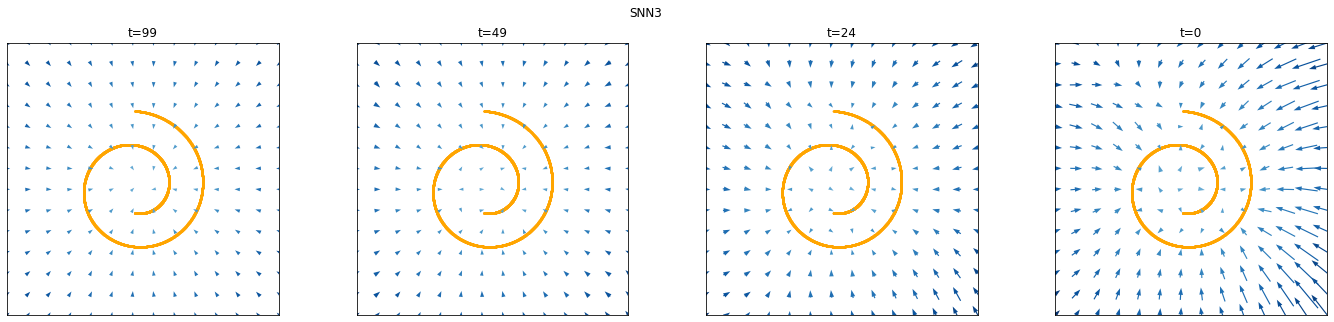

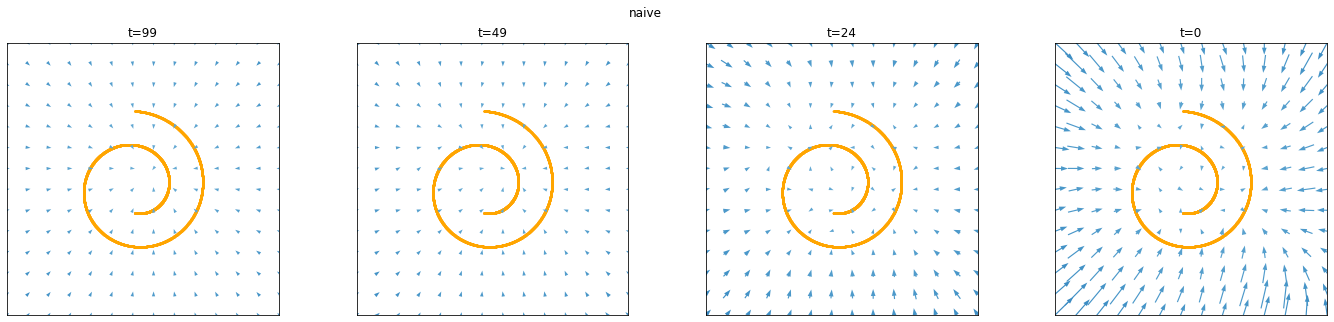

In [239]:
# the posterior
from likelihood_utils import compute_diffuser_score, compute_occlusion_score
from generate_data import load_trimodal_data
dataset = gt_manifold

# display the flow field for the prior sampler 
lim = 2
score_lim = lim
lims = [-lim, lim]
num_samples = 14

temps = torch.tensor([[0], [24], [49], [99]], dtype=torch.float)  # lim=2
print(temps.detach().numpy().T.reshape(-1).astype(int))

def calculate_flow_fields_during_sampling(model, temps, arrow_size_control):
    score_temps = []
    for t in temps:
        score_xs = []
        score_ys = []
        for sample_y in np.linspace(-lim, lim, num_samples):
            for sample_x in np.linspace(-lim, lim, num_samples):
                
                # compute the score 
                x = torch.tensor([[sample_x, sample_y]], dtype=torch.float)
                diffuser_score = model(x, t).detach()
                
                # control the range of arrow sizes
                arrow_size_control = arrow_size_control  # must be less than 1
                
                vector_mags = torch.norm(diffuser_score, dim=1)
                for i in range(diffuser_score.shape[0]):
                    diffuser_score[i] = diffuser_score[i]/(vector_mags[i] * arrow_size_control**vector_mags[i])
                
                score_x, score_y = -diffuser_score[0,0], -diffuser_score[0,1]
                
                # collect data
                score_xs.append(score_x)
                score_ys.append(score_y)
        score_xs = torch.stack(score_xs).reshape(num_samples, num_samples)
        score_ys = torch.stack(score_ys).reshape(num_samples, num_samples)

        score_temps.append(torch.stack((score_xs, score_ys), dim=2))
        color = np.hypot(score_xs, score_ys)**2
    score_temps = torch.stack(score_temps)
    print(score_temps.shape)
    return score_temps, color


# ----------------------------------- plot SNN3 ----------------------------------- #
model = SNN3(num_hidden)
model = load_model_weights(model, 'snn3', 2, device)

score_temps, color = calculate_flow_fields_during_sampling(model, temps, arrow_size_control=0.90)

fig, axes = plt.subplots(1, len(temps), figsize=(24, 5), sharey=True)
# choose the temperature
for t in reversed(range(len(temps))):
    score_xs = score_temps[t, :, :, 0]
    score_ys = score_temps[t, :, :, 1]
    
    ax = axes[len(temps)-t-1]
    ax.scatter(*dataset[:, :2].T, s=1, alpha=0.8, c='orange')
    q = ax.quiver(np.linspace(-lim, lim, num_samples), np.linspace(-lim, lim, num_samples), 
            score_xs, score_ys, 
            color,
            cmap='Blues',
            angles='xy', scale_units='xy', pivot='mid',
            scale=15,
            headwidth=4,
            headlength=6,
            headaxislength=6,
            clim=(-0, 2))
    # ax.plot(ls * v[0], ls * v[1], c='green', alpha=0.6, label='constraint')
    # plt.clim(0,120)
    ax.set(title=f't={int(temps[t].item())}')
    ax.set_aspect('equal')
    ax.set(xlim=lims, ylim=lims)
    fig.suptitle('SNN3')
    from rad_utils import remove_all_ticks_and_labels
    remove_all_ticks_and_labels(ax)

# ----------------------------------- plot naive ----------------------------------- #
model = NoiseConditionalEstimatorConcat(num_hidden=256)
model = load_model_weights(model, 'unconditional-concat', 15, device)

score_temps, color = calculate_flow_fields_during_sampling(model, temps, arrow_size_control=0.96)

fig, axes = plt.subplots(1, len(temps), figsize=(24, 5), sharey=True)
# choose the temperature
for t in reversed(range(len(temps))):
    score_xs = score_temps[t, :, :, 0]
    score_ys = score_temps[t, :, :, 1]
    
    ax = axes[len(temps)-t-1]
    ax.scatter(*dataset[:, :2].T, s=1, alpha=0.8, c='orange')
    q = ax.quiver(np.linspace(-lim, lim, num_samples), np.linspace(-lim, lim, num_samples), 
            score_xs, score_ys, 
            color,
            cmap='Blues',
            angles='xy', scale_units='xy', pivot='mid',
            scale=15,
            headwidth=4,
            headlength=6,
            headaxislength=6,
            clim=(-0, 2))
    # ax.plot(ls * v[0], ls * v[1], c='green', alpha=0.6, label='constraint')
    # plt.clim(0,120)
    ax.set(title=f't={int(temps[t].item())}')
    ax.set_aspect('equal')
    ax.set(xlim=lims, ylim=lims)
    fig.suptitle('naive')
    from rad_utils import remove_all_ticks_and_labels
    remove_all_ticks_and_labels(ax)


# no sampling noise with naive model
I wonder if the noise inside the model helps with letting it stay on the manifold? The question is, why don't all diffusion models simply ignore the sampling noise? 

